# Use multichannel Trained GAN

last edited: OCt 12, 2020

In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
from photutils import create_matching_kernel
from skimage.transform import downscale_local_mean
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import numpy as np
import h5py

import astropy.wcs as wcs
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import ndimage
from PIL import Image

import cv2


%matplotlib inline

#### Read in GAN generator and trained weights

In [2]:
device = torch.device("cpu")
ngpu = int(3)
nz = int(100)
ngf = int(64)
ndf = int(64)
nc=7


class Shoobygen(nn.Module):

    def __init__(self,ngpu):
        super(Shoobygen, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            nn.Conv2d(nc, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            nn.ConvTranspose2d( ngf*4, ngf * 8, 3, 3, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 7, 1, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            
            nn.ConvTranspose2d(ngf*4, nc, 4, 1, 0, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
            output1 = output[:,:,:,:]

        else:
            output = self.main(input)
            output1 = output[:,:,:,:]

        return output1


netS = Shoobygen(ngpu).to(device)
netS.load_state_dict(torch.load('netG_epoch_483.pth',map_location='cpu'))


<All keys matched successfully>

Read GOODS-S sample data in seven bands 

(7, 64, 64)


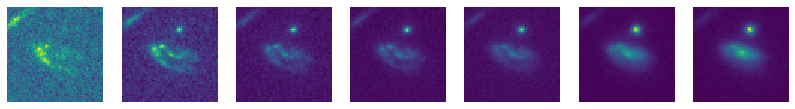

In [158]:
hf = h5py.File('Sample_test.hdf5', 'r')
hf.keys()

boz=np.random.randint(1,2500)
mm = hf['test_img'][boz, ...]
plt.figure(figsize=(14,3))
for i in range(7):
    plt.subplot(1,7,i+1)
    plt.imshow(mm[i,:,:],origin='lower')
    plt.axis('off')
hf.close()

print(np.shape(mm))
real_cpu = torch.tensor(mm.reshape((1,7,64,64)))

In [159]:
hi_psfs = ['psf_b.fits','psf_v.fits', 'psf_i.fits','psf_i.fits', 'psf_z.fits', 'psf_j.fits', 'psf_h.fits']
lo_psfs = ['PSF_subaru_i.fits','PSF_subaru_i.fits','PSF_subaru_i.fits','PSF_subaru_i.fits',
           'PSF_subaru_i.fits','PSF_subaru_i.fits','PSF_subaru_i.fits']

kernel = np.zeros((1,nc,20,20))
for i in range(len(hi_psfs)):
    psf = pyfits.getdata('../psfs/'+hi_psfs[i])
    psf = downscale_local_mean(psf,(3,3))
    psf = psf[8:-8,8:-8]#[22:-22,22:-22]

    psf_hsc = pyfits.getdata('../psfs/'+lo_psfs[i])
    psf_hsc = psf_hsc[2:42,2:42]
    a = create_matching_kernel(psf,psf_hsc)
    kernel[0,i,:,:] = a[10:-10,10:-10]

kernel = torch.Tensor(kernel)
kernel =  kernel.float()
kernel = kernel.to(device)
img2 = torch.tensor(np.zeros((1,nc,22,22)))
for ch in range(real_cpu.shape[1]):
    imagetoconvolv = real_cpu[0,ch,:,:].reshape(-1,1,64,64)
    kerneltoconvolv = kernel[:,ch,:,:].reshape(-1,1,20,20)
            
    a = F.conv2d(imagetoconvolv, kerneltoconvolv).data.squeeze()
    a = a.reshape(-1,1,45,45)
    downsampled = F.upsample(a,scale_factor=1/2,mode='bilinear')
    img2[:,ch,...] = downsampled[:,0,:,:]
            
            
img = img2.view(-1,nc,22,22)
img = img+0.25*torch.rand_like(img)
img = img[:,:,:,:].float()#.cuda()

fake = netS(img)
print(fake.shape)
fd = fake.detach()
fd = fd.cpu()

torch.Size([1, 7, 64, 64])


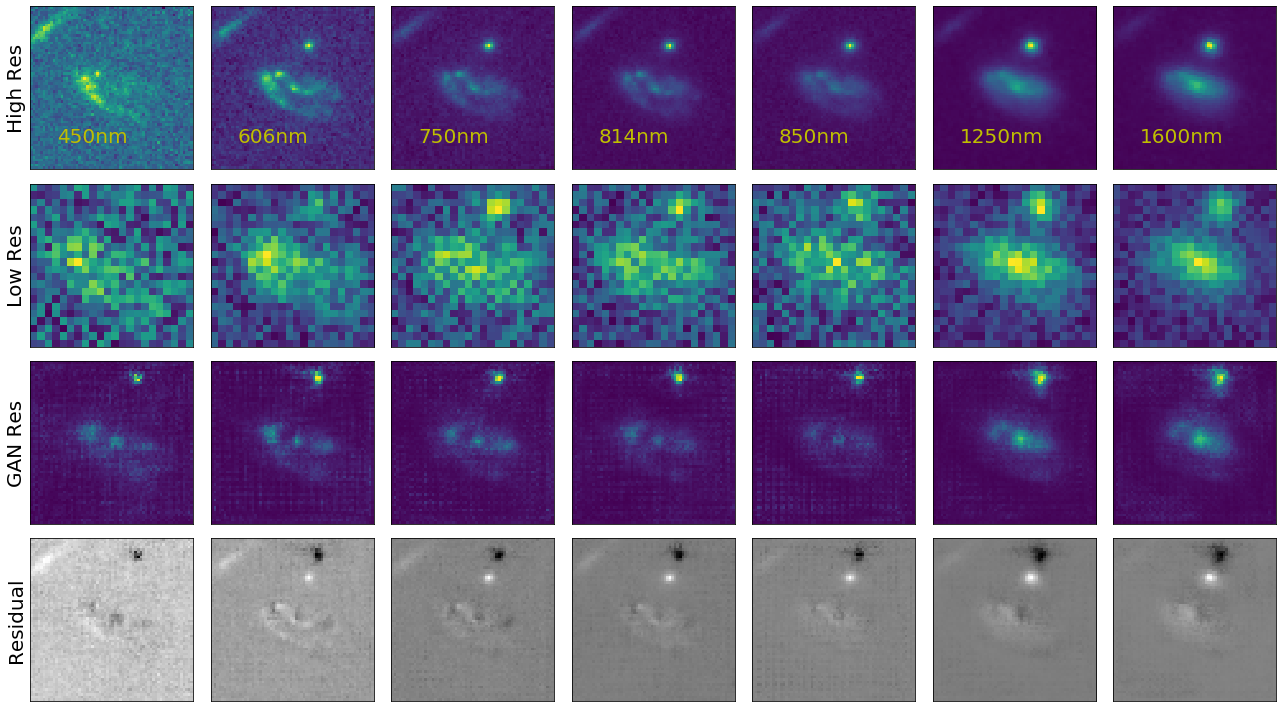

In [160]:
plt.figure(figsize=(18,10))

filts = ['450nm','606nm','750nm','814nm','850nm','1250nm','1600nm']
for i in range(7):
        
    plt.subplot(4,7,i+1)
    plt.imshow(mm[i,:,:],origin='lower')
    plt.text(10,10,filts[i],color='y',size=20)
    
    plt.xticks([])
    plt.yticks([])
    if i ==0:
        plt.ylabel('High Res',size=20)
    
    plt.subplot(4,7,7+i+1)
    plt.imshow(img[0,i,:,:],origin='lower')
    plt.xticks([])
    plt.yticks([])
    if i ==0:
        plt.ylabel('Low Res',size=20)   
        
    plt.subplot(4,7,14+i+1)
    plt.imshow(fd[0,i,:,:],origin='lower')
    plt.xticks([])
    plt.yticks([])
    if i ==0:
        plt.ylabel('GAN Res',size=20)  
        
    plt.subplot(4,7,21+i+1)
    plt.imshow(real_cpu[0,i,:,:]-fd[0,i,:,:],origin='lower',cmap='gray')
    plt.xticks([])
    plt.yticks([])
    if i ==0:
        plt.ylabel('Residual',size=20)

    
plt.tight_layout()
#plt.savefig('../plots/multi.png')